In [1]:
using ImagePhantoms
using ImageGeoms: ImageGeom, axesf
using MIRT
using MIRTjim
using Plots
using FFTW
using Random
using LinearMapsAA
using LinearAlgebra
using MAT

In [2]:
# read in data from mat file
kdata = matread("./data/2D_T1_data.mat")["kData"];

# get sizes
nd = ndims(kdata) - 1; # number of image dimensions
N = size(kdata)[1:nd]; # image size
Q = size(kdata, nd + 1); # number of channels

In [3]:
# set PISCO parameters
τ = Int(3); # neighborhood size (radius)
N_cal = 32; # size of calibration region
σ_thresh = 0.002; # threshold for singular values
d_sk = 50; # sketch dimension for SVD of ChC (overestimation of the rank)

# set PISCO techniques
kernel_shape = 1; # (0 for rect, 1 for circle)
fft_conv_mtx = 0; # option to approximate ChC with FFTs

In [4]:
# create some helper functions
even_RL = x -> Int(1 - mod(x, 2.0)); # helps with using odd data points

# gaussian window function (reflects matlab gausswin.m)
function gausswin(N,α)
    L = N-1;
    n = (0:L) .- L/2;
    return exp.(-0.5 * (α * n / (L/2)).^2);
end

# function to generate grid points
function grid(xs::AbstractVector...)
    nd = length(xs);
    N = prod(length.(xs));
    xgrd = zeros(eltype(xs[1]), N, nd);
    for d in 1:nd
        shape = ntuple(j -> j == d ? length(xs[d]) : 1, nd);
        rep = ntuple(j -> j == d ? 1 : length(xs[d]), nd);
        xgrd[:, d] = repeat(reshape(xs[d], shape), rep...)[:];
    end
    return xgrd
end

grid (generic function with 1 method)

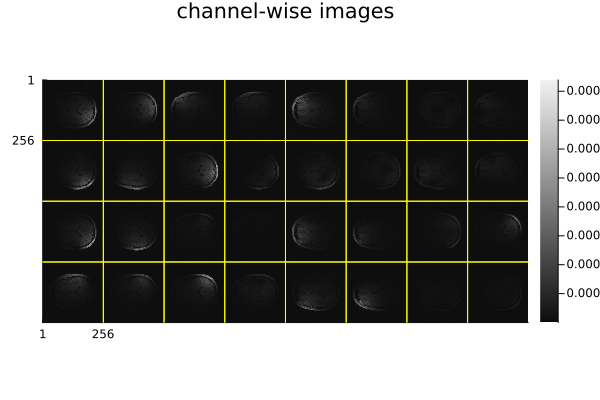

In [5]:
# get aliased image
idata = fftshift(ifft(ifftshift(kdata,1:nd),1:nd),1:nd);
jim(idata, title="channel-wise images")

In [12]:
# get calibration data
cal_idcs = [ceil.(Int,N[d]/2) + even_RL(N[d]/2) .+ (-floor(Int,N_cal/2):floor(Int,N_cal/2)-even_RL(N_cal/2)) for d in 1:nd];
kcal = kdata[cal_idcs..., :];

# create neighborhood grid points
Λ_idcs = grid([-τ:τ for d in 1:nd]...);

# mask out edges if using circular kernel
if kernel_shape == 1
    cmask = vec(sum(Λ_idcs.^2, dims=2)) .<= τ^2;
    Λ_idcs = Λ_idcs[cmask,:];
end

# get patch size
Λ_len = size(Λ_idcs,1);

By the SILP relationship:

\begin{equation*}
    \sum_{\vec{l} \in \Lambda} \tilde{s}(\vec{l} - \vec{k}) \tilde{f_p}(\vec{l}) \approx 0, \quad \forall \vec{k} \in \Gamma, \quad \forall p = 1,...P
\end{equation*}

This can be represented as a matrix-vector product:

\begin{equation*}
    Cf_p \approx 0,  \quad \forall p = 1,...P
\end{equation*}

Where $f_p$ is a vector representing the SILP kernel defined on the set of points in kspace $\Lambda$. C is a convolution matrix structured as:

\begin{equation*}
    C = \begin{bmatrix}
        s[]
    \end{bmatrix}
\end{equation*}

In other words, $f_p \in \mathcal{N}(C) \subset \mathbb{C}^{|\Lambda|}, \quad \forall p=1,...P$. 

In [ ]:
# form the convolution matrix
if fft_conv_mtx == 1 # calculate ChC directly using FFT-based convolution approach
    # TODO
else # calculate ChC by first calculating C
    C = zeros(ComplexF64, (N_cal .- 2*τ .- even_RL.(N_cal))^nd, Λ_len, Q)
    k = grid(ntuple(d -> τ+1+even_RL(N_cal):N_cal-τ, nd)...); # grid of shift points
    for i in 1:size(k,1)
        idcs = ntuple(d -> k[i, d] .+ Λ_idcs[:, d], nd); # shifted indicies
        for q in 1:Q
            C[i,:,q] .= getindex.(Ref(kcal), idcs..., q);
        end
    end
    C = reshape(C, ((N_cal .- 2*τ .- even_RL.(N_cal))^nd, Λ_len*Q)); # reshape
    ChC = C'*C;
end

In [7]:
# take the SVD of C to find its null space
(~,σ,V) = svd(ChC);
r = count(σ/σ[1] .> σ_thresh);
V0 = V[:, 1:r];
#V0 = V[:, r+1:end]; # get the null space basis of C
P = size(V0, 2); # number of null space basis vectors

In [8]:
# ft the filters to the image domain
f_p = zeros(ComplexF64, P, Q, N...);
for i in 1:Λ_len
    f_p[:, :, [Int(N[d]/2) + Λ_idcs[i,d] for d in 1:nd]...] .= reshape(conj.(V0'), P, Λ_len, Q)[:,i,:];
end
h_p = fftshift(ifft(ifftshift(f_p, 3:nd+2), 3:nd+2), 3:nd+2);

In [9]:
# form H matrix
H = reshape(h_p,P,Q,prod(N));

# estimate sensitivity maps
smaps_est = zeros(ComplexF64, Q, prod(N));
ev_est = zeros(ComplexF64, Q, prod(N));
for x in 1:prod(N) # loop through vo/pixels
    # estimate sensitivity at x as last null space vector of H(x)
    (~,σ,V) = svd(H[:,:,x]'*H[:,:,x]);
    smaps_est[:,x] = V[:,1];
    ev_est[:,x] = σ;
    #smaps_est[:,x] = V[:,end];
end
smaps_est = permutedims(reshape(smaps_est, Q, N...),((2:nd+1)...,1));

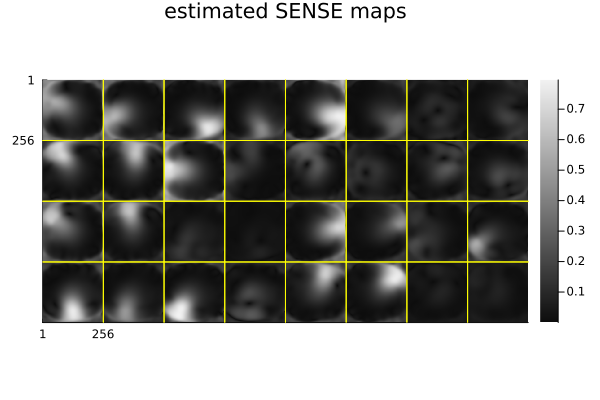

In [10]:
# show the sensitivity maps
jim(smaps_est, title="estimated SENSE maps")

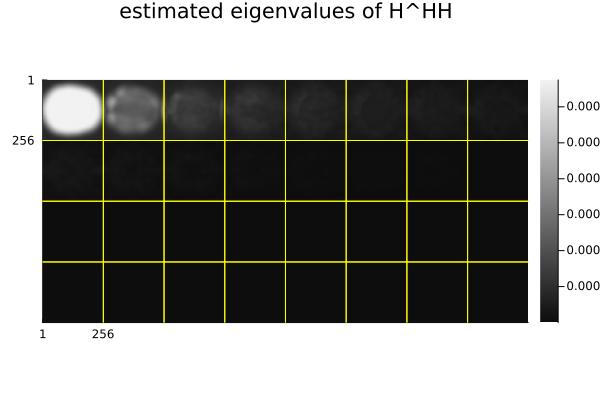

In [11]:
# show the eigenvalues of H'H
jim(reshape(ev_est', N..., Q), title="estimated eigenvalues of H^HH")

To do:
- calculate NPR based on changes:
    - estimate ChC with FFT and see change in NPR